# Imports

In [2]:
import pandas as pd
import re
import joblib

In [3]:
data = pd.read_csv('../../Data/magicbricks_lr.csv')

# Preprocessing

## Filtering Cols

In [4]:
data = data[data['Location_Score'] > 0]

In [5]:
# Columns to drop

def get_column_status():
    """Make a df of all columns and their num nan values, dtype, num unique values"""
    cols = data.columns.tolist()
    col_status = pd.DataFrame(columns=['column', 'num_nan', 'dtype', 'num_unique'])
    for col in cols:
        col_status.loc[len(col_status)] = [col, data[col].isna().sum(), data[col].dtype, data[col].nunique()]
    return col_status

In [6]:
status = get_column_status()
status.sort_values(by='num_nan', ascending=False)

,column,num_nan,dtype,num_unique
13,Unnamed: 13,1179,float64,0
49,Unnamed: 49,1179,float64,0
45,Unnamed: 45,1179,float64,0
47,Unnamed: 47,1179,float64,0
48,Unnamed: 48,1179,float64,0
46,Unnamed: 46,1179,float64,0
35,Car Parking,1177,object,1
34,Possession by,1173,object,4
26,Floors allowed for construction,1146,float64,6
33,RERA ID,1131,object,34


In [7]:
# For rows where Car parking has missing values check if Car Parking has a value and if so, replace the missing value with the value
missing_indices = data[data['Car parking'].isna()].index
for index in missing_indices:
    if not pd.isna(data.loc[index, 'Car Parking']):
        data.loc[index, 'Car parking'] = data.loc[index, 'Car Parking']

In [8]:
cols_to_keep = ['Bedrooms', 'Car parking', 'Furnishing', 'Bathrooms', 'Floor', 'Status', 'Price Breakup', 'Location_Score']
filtered_data = data[cols_to_keep]

## Feature Engineering

In [9]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:

    def get_price(price: str):
        """
        '₹ 1.72 Cr ₹ 12,03,923 Stamp Duty, Registration Charges ₹ 2,800 Monthly\nSee Other Charges' -> ₹ 1.72 Cr
        '₹ 1.58 Cr ₹ 11,05,986 Stamp Duty, Registration Charges ₹ 2,500 Monthly\nSee Other Charges' -> ₹ 1.58 Cr
        '₹ 1.27 Cr ₹ 8,88,930 Stamp Duty, Registration Charges ₹ 2,850 Monthly\nSee Other Charges' -> ₹ 1.27 Cr
        """
        if type(price) == str:
            num = re.search(r'[.\d]+', price).group()
            suffix = re.search(r'Lac|Cr', price).group()
            if suffix == 'Lac':
                num = float(num)
            elif suffix == 'Cr':
                num = float(num) * 100
            return int(num)


    data = data.copy()
    # Bedrooms
    digits_regex = re.compile(r'[\-\d]+')
    data.loc[:, 'Bedrooms'] = data['Bedrooms'].apply(lambda x: int(digits_regex.search(x).group()) if type(x) == str else x)
    data.loc[:, 'Bedrooms'] = data['Bedrooms'].fillna(data['Bedrooms'].mode()[0])
    data.loc[:, 'Bedrooms'] = data['Bedrooms'].astype(int)

    # Car parking
    # Find all numbers and add
    data.loc[:, 'Car parking'] = data['Car parking'].apply(lambda x: int(sum(map(int, digits_regex.findall(x)))) if type(x) == str and digits_regex.search(x) else x)
    data.loc[:, 'Car parking'] = data['Car parking'].apply(lambda x: x.replace('None', '0') if 'None' in str(x) else x)
    data.loc[:, 'Car parking'] = data['Car parking'].fillna(data['Car parking'].mode()[0])
    data.loc[:, 'Car parking'] = data['Car parking'].astype(int)

    # Furnishing
    data.loc[:, 'Furnishing'] = data['Furnishing'].fillna(data['Furnishing'].mode()[0])
    data.loc[:, 'Furnishing'] = data['Furnishing'].astype('category')

    # Bathrooms
    data.loc[:, 'Bathrooms'] = data['Bathrooms'].fillna(data['Bathrooms'].mode()[0])
    data.loc[:, 'Bathrooms'] = data['Bathrooms'].astype(int)
    
    # Floor
    data.loc[:, 'Floor'] = data['Floor'].apply(lambda x: x.replace('Ground', '0') if type(x) == str else x)
    data.loc[:, 'Floor'] = data['Floor'].apply(lambda x: x.replace('Upper Basement', '-1') if type(x) == str else x)
    data.loc[:, 'Total Floors'] = data['Floor'].apply(lambda x: int(digits_regex.findall(x)[1]) if type(x) == str else x)
    data.loc[:, 'Floor'] = data['Floor'].apply(lambda x: int(digits_regex.findall(x)[0]) if type(x) == str else x)
    data.loc[:, 'Total Floors'] = data['Floor'].fillna(data['Total Floors'].mode()[0])
    data.loc[:, 'Floor'] = data['Floor'].fillna(data['Floor'].mode()[0])
    data.loc[:, 'Total Floors'] = data['Total Floors'].astype(int)
    data.loc[:, 'Floor'] = data['Floor'].astype(int)

    # Location_Score
    data.dropna(subset=['Location_Score'], inplace=True)

    # Status
    data.loc[:, 'Status'] = data['Status'].fillna(data['Status'].mode()[0])
    data.loc[:, 'Status'] = data['Status'].astype('category')

    # Price Breakup
    data.loc[:, 'Price Breakup'] = data['Price Breakup'].apply(get_price)
    data.dropna(subset=['Price Breakup'], inplace=True)


    return data

In [10]:
modified_data = feature_engineering(filtered_data)
modified_data.to_csv('../../Data/magicbricks_lr_modified.csv', index=False)

In [11]:
def encode(data: pd.DataFrame) -> pd.DataFrame:
    data = data.copy()
    cat_cols = data.select_dtypes(include=['category']).columns.tolist()
    for col in cat_cols:
        data.loc[:, col] = data[col].cat.codes

    return data

In [12]:
encoded_data = encode(modified_data)
encoded_data.to_csv('../../Data/magicbricks_lr_encoded.csv', index=False)

## Outlier Removal

In [13]:
# Remove Price Breakup outliers based on IQR
def remove_outliers(data: pd.DataFrame) -> pd.DataFrame:
    data = data.copy()
    data.drop(data[data['Price Breakup'] > data['Price Breakup'].quantile(0.95)].index, inplace=True)
    data.drop(data[data['Price Breakup'] < data['Price Breakup'].quantile(0.05)].index, inplace=True)
    return data

inlier_data = remove_outliers(encoded_data)

In [14]:
data = inlier_data

data.shape

(1072, 9)

# Training

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [16]:
X, y = data.drop(['Price Breakup'], axis=1), data['Price Breakup']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

### Scale

In [18]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_valid = sc.transform(X_valid)
X_test = sc.transform(X_test)

### Linear Regression

In [19]:
from sklearn.linear_model import LinearRegression

In [20]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [21]:
# Score
print(f'MSE: {mean_squared_error(y_valid, lr.predict(X_valid))}')
print(f'Score: {lr.score(X_valid, y_valid)}')

MSE: 7702.391710168633
Score: 0.26469657979780525


### SVR

In [21]:
from sklearn.svm import SVR

In [39]:
sv = SVR()
sv.fit(X_train, y_train)

SVR()

In [40]:
# Score
print(f'MSE: {mean_squared_error(y_valid, sv.predict(X_valid))}')
print(f'Score: {sv.score(X_valid, y_valid)}')

MSE: 8597.780949393913
Score: 0.17921887432803563


### Random Forest

In [24]:
from sklearn.ensemble import RandomForestRegressor

In [42]:
rf = RandomForestRegressor(n_estimators=1000, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=42)

In [43]:
# Score
print(f'MSE: {mean_squared_error(y_valid, rf.predict(X_valid))}')
print(f'Score: {rf.score(X_valid, y_valid)}')

MSE: 7963.73691787895
Score: 0.23974744291748395


### XGBoost

In [29]:
from xgboost import XGBRegressor

In [30]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [31]:
# Score
print(f'MSE: {mean_squared_error(y_valid, xgb.predict(X_valid))}')
print(f'Score: {xgb.score(X_valid, y_valid)}')

MSE: 9407.577867836348
Score: 0.10191217970566047


### MLPRegressor

In [32]:
from sklearn.neural_network import MLPRegressor

In [33]:
mlp = MLPRegressor(max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)

/Users/macbookpro/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(max_iter=1000, random_state=42)

In [34]:
# Score
print(f'MSE: {mean_squared_error(y_valid, mlp.predict(X_valid))}')
print(f'Score: {mlp.score(X_valid, y_valid)}')

MSE: 8831.038006939058
Score: 0.15695115299508744


In [46]:
for y_true, y_predict in zip(y_valid, lr.predict(X_valid)):
    print(f'{y_true} -> {y_predict}')

28 -> 74.90953272014757
107 -> 157.52035659218677
76 -> 111.50561812467527
140 -> 108.65921021022584
44 -> 202.36756858279156
225 -> 135.9746471200466
325 -> 242.4189597605154
125 -> 122.47279098530126
260 -> 205.3943308045002
165 -> 247.4248313925117
110 -> 229.1500001685955
67 -> 112.1226813234508
35 -> 115.49597528304615
72 -> 103.67107371623914
158 -> 274.64397186983194
105 -> 96.34772627609732
114 -> 74.90953272014757
350 -> 389.1046989624474
323 -> 135.83804700972166
175 -> 231.07107076304914
150 -> 85.73665495133878
113 -> 96.7441314897892
35 -> 89.29030321819334
35 -> 69.96169990398528
312 -> 181.80126231571882
238 -> 199.43098351471252
55 -> 98.17861971692135
113 -> 104.10166332888458
120 -> 93.28066037656424
225 -> 142.79917363512516
77 -> 123.47057032091708
100 -> 85.86713578279281
35 -> 62.59804878601902
254 -> 195.44062635634162
36 -> 67.55200088105218
165 -> 119.48633244141706
229 -> 309.2975557950293
48 -> 191.63674278410085
38 -> 100.11742544938456
400 -> 244.3919498919

## Final Model

In [22]:
model = lr

In [23]:
# Save Model
joblib.dump(model, '../../Code/Modelling/Models/model.pkl', compress=9)

['../../Code/Modelling/Models/model.pkl']

## Feature Importance

In [52]:
from matplotlib import pyplot as plt
import seaborn as sns

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

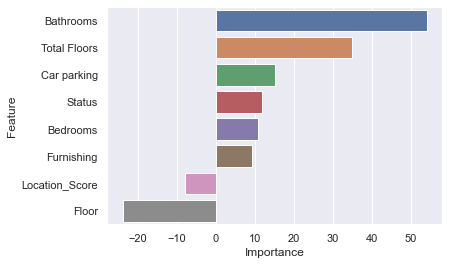

In [53]:
# Plot Feature importance of Linear Regression Model
imp = pd.DataFrame(sorted(zip(X.columns, model.coef_), key=lambda x: x[1]), columns=['Feature', 'Importance'])
imp.sort_values(by='Importance', inplace=True, ascending=False)
sns.barplot(x='Importance', y='Feature', data=imp)